## *Flight fare prediction*
------------

- Dataset acquired from [kaggle](https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh/)
- The task at hand is to predict the price of the journey for a particular flight 

#### Importing the required libraries 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
import warnings
from prettytable import PrettyTable
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

#### Loading the dataset 

In [6]:
data=pd.read_excel("Data_Train.xlsx")

#### Understanding the data at hand

In [7]:
data.shape

(10683, 11)

In [8]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


- We have 11 columns with 10 independent features and 1 dependent feature
- There are a total of 10683 data points
---------------

In [9]:
data["Source"].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [10]:
data["Destination"].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

- We have 5 unique values in source and 6 in destination
- There is Delhi and New Delhi in the destination column
- Different airlines use both the names interchangeably,usually referring to the same airport
- Hence it's safe to rename either one as the other 
------------

In [11]:
data["Destination"]= data["Destination"].replace("New Delhi", "Delhi") 

In [12]:
data["Destination"].value_counts()

Cochin       4537
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [13]:
data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

- There are 12 airlines that are considered in the dataset, some having only a few points 

In [14]:
data["Additional_Info"].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

- Most of the points are "No Info" 
- Its is probably a good idea to drop this column as we are bound to not get much value

-----

#### Checking for null values

In [15]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [16]:
data["Route"].isnull().values.any()

True

In [17]:
data["Total_Stops"].isnull().values.any()

True

In [18]:
data.dropna(inplace=True)

In [19]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [20]:
data.shape

(10682, 11)

- There are only 2 null values and both in the same row
- Hence, we can confidently drop the row
---------

### EDA-Exploratory data analysis

#### Checking if Airline affects the price

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

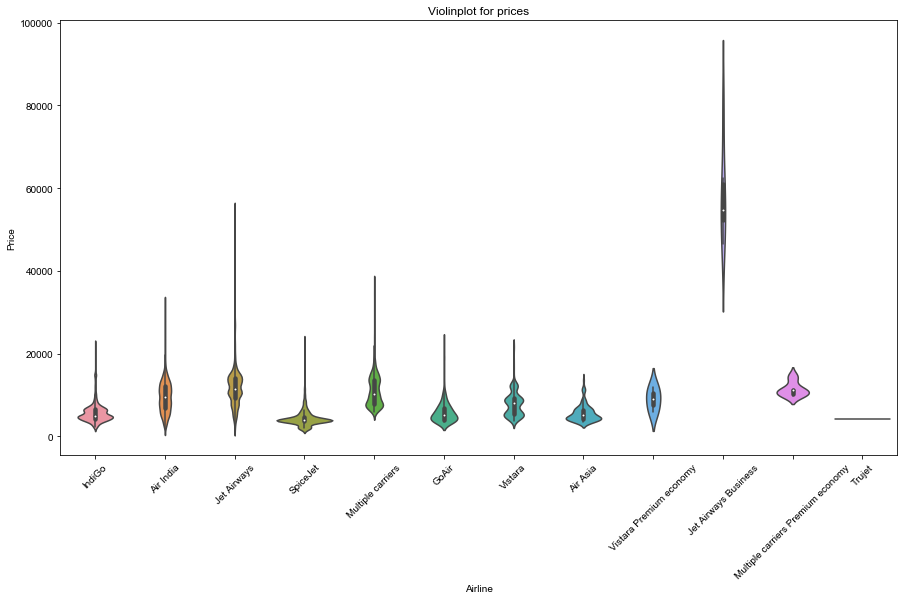

In [21]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
violin = sns.violinplot(x="Airline", y="Price", data=data)
plt.xticks(rotation=45)
plt.title("Violinplot for prices")
plt.plot

- With the violin plot,we can observe different airline affect the price. 
- Jet Airways Business is being priced higher than normal
- That might be an outlier or as seen at the beginning Jet Airways Business has very few points which might make it biased 

In [22]:
z=data.groupby(['Airline'])['Price'].mean()  #looking at the average of the prices for airlines
xx=list(z)

In [23]:
g=list(data.Airline.unique())

In [24]:
g.sort()
print(g)

['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways', 'Jet Airways Business', 'Multiple carriers', 'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara', 'Vistara Premium economy']


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

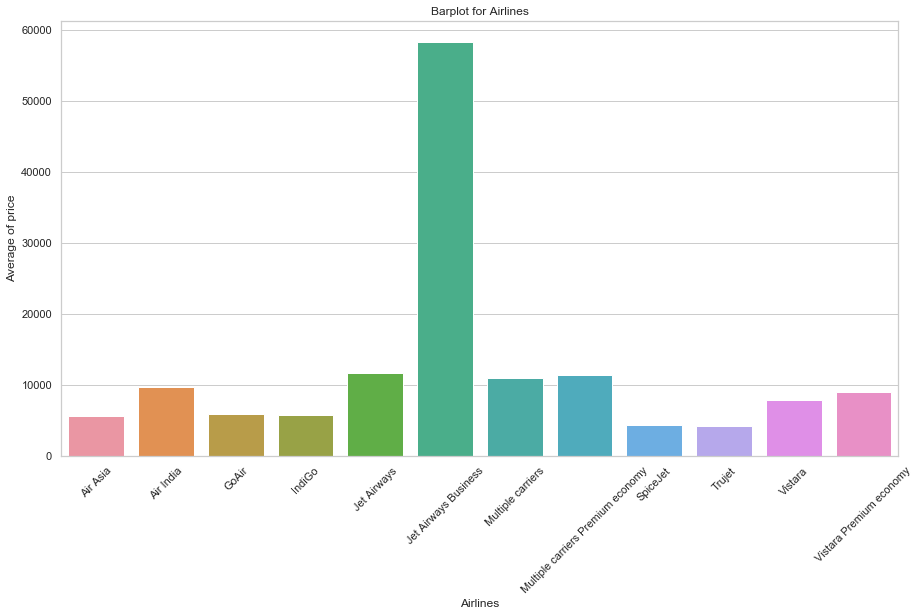

In [25]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
ax = sns.barplot(x=g, y=xx,ax=ax)
plt.xticks(rotation=45)
plt.xlabel("Airlines")
plt.ylabel("Average of price")
plt.title("Barplot for Airlines")
plt.plot

- There is a good chance that Jet Airways Business has an outlier 
- Since there are only 3 data points for the same , we will drop Jet Airways Business

In [26]:
indexNames1 = data[data['Airline'] == "Jet Airways Business" ].index

data.drop(indexNames1 , inplace=True)

----------

#### Checking if Source and Destination affects the price

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

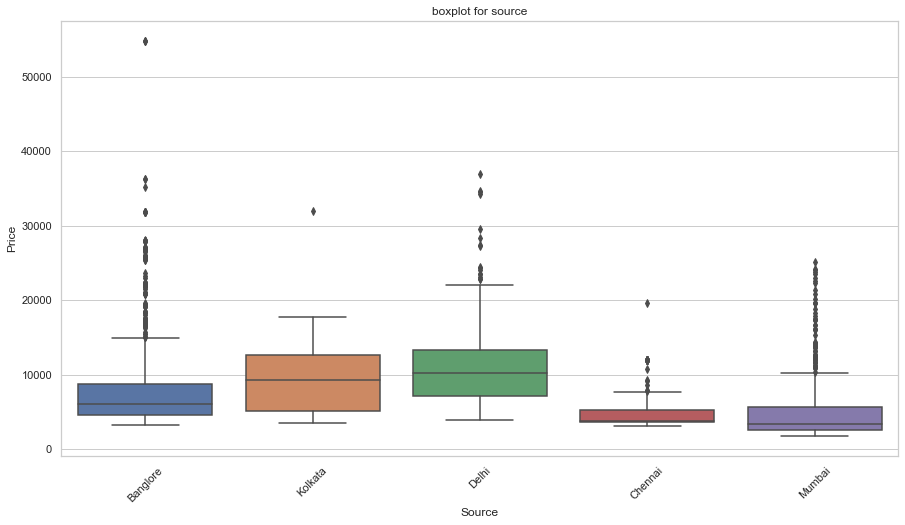

In [27]:
ig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
violin = sns.boxplot(x="Source", y="Price", data=data)
plt.xticks(rotation=45)
plt.title("boxplot for source")
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

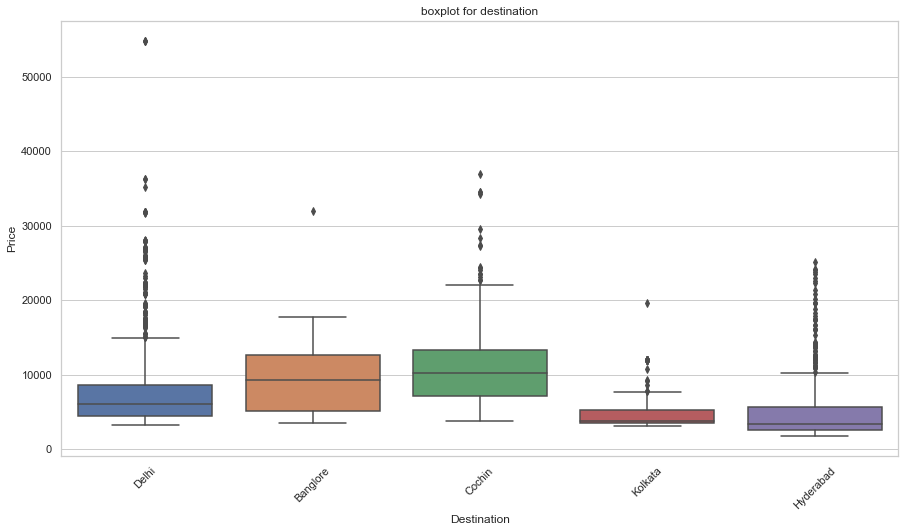

In [28]:
ig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
violin = sns.boxplot(x="Destination", y="Price", data=data)
plt.xticks(rotation=45)
plt.title("boxplot for destination")
plt.plot

- Using the box plot , the difference in price for each source is notecible 
- The 50th percentile for each source is considerably different 
- The same observation can be made with destination

#### Checking if total stops affect the price

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

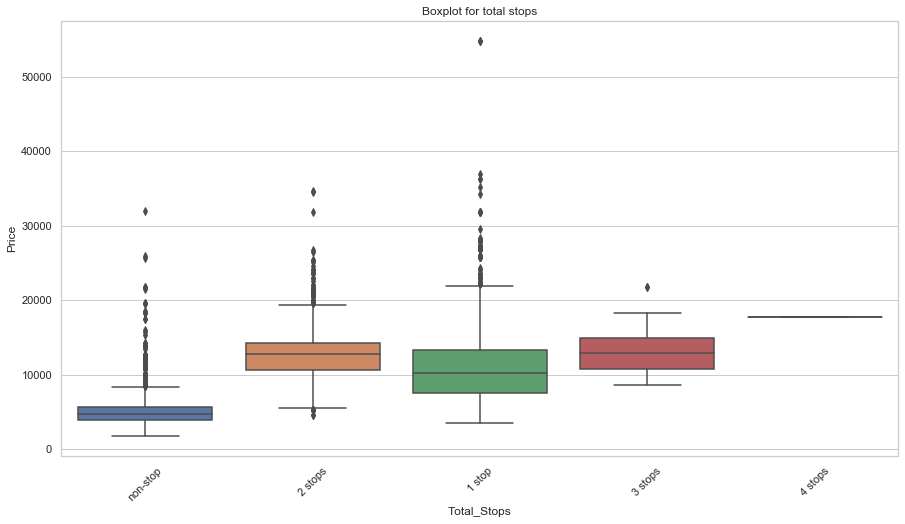

In [29]:
ig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="whitegrid")
violin = sns.boxplot(x="Total_Stops", y="Price", data=data)
plt.xticks(rotation=45)
plt.title("Boxplot for total stops")
plt.plot

- As observed above, total stops also affect the price 

### Featurization (Numerical Data)

#### Extracting the day and the month from Date_of_Journey column

In [30]:
data["day_of_journey"]=pd.to_datetime(data["Date_of_Journey"],format="%d/%m/%Y").dt.day
data["month_of_journey"]=pd.to_datetime(data["Date_of_Journey"],format="%d/%m/%Y").dt.month

- Here we are getting the exact month and the day using the datetime library

In [31]:
data.drop(["Date_of_Journey"],axis=1,inplace=True) #dropping the column sice we have derived the necessary information

----------

#### Extracting the hour and minute from departure time 

In [32]:
data["dep_hour"]=pd.to_datetime(data["Dep_Time"]).dt.hour
data["dep_min"]=pd.to_datetime(data["Dep_Time"]).dt.minute

In [33]:
data.drop(["Dep_Time"],axis=1,inplace=True) #dropping the column

In [34]:
data.drop(["Duration"],axis=1,inplace=True)
data.drop(["Arrival_Time"],axis=1,inplace=True) 

- Dropping duration and arrival time as they don't really add any value to the app that we are going to deploy 

---------

#### Getting total time travelled

#### Dropping additional info and route

In [36]:
data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

- As seen above Additional info has "no info" for mist of the points 
- The route column gives the same information as the total stops
- Hence , we are dropping both these columns

### Categorical data

#### Featurising total stops

In [37]:
data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

- Since total stops is a **Categorical Ordinal data**, we are going assign the stops their respective numbers
- This is an easier way to featurize this as there are only 5 types of stops

#### Featurising Airline

In [38]:
air_train = data[["Airline"]]
air_train = pd.get_dummies(air_train, drop_first = True) #featurising Airline by creating dummy variable
data.drop(["Airline"],axis=1,inplace=True)

#### Featurising source

In [39]:
source_train = data[["Source"]]
source_train = pd.get_dummies(source_train, drop_first = True)
data.drop(["Source"],axis=1,inplace=True)           

#### Featurusing destination

In [40]:
dest_train = data[["Destination"]]
dest_train = pd.get_dummies(dest_train,drop_first = True)
data.drop(["Destination"],axis=1,inplace=True)

- Airline,source and destination are **Categorical Nominal data**,Hence using the dummy variable feature from pandas
- Care is taken to avoid the dummy variable trap by dropping the first variable

-------

## Modelling

#### Merging

In [41]:
x_tr=pd.concat([data, air_train, source_train, dest_train], axis = 1) #merging all the features 

In [42]:
y = x_tr['Price'].values #seperating the dependent feature 
X = x_tr.drop(['Price'], axis=1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42) #data is split in to train and test

In [44]:
print(X_train.shape)
print(X_test.shape)

(8007, 23)
(2669, 23)


- The train data now contains 8007 points with 26 features 
- Test data contains 2669 points with same 26 features 

#### Model 1--KNN

##### Hyperparameter tuning

In [45]:
knnparams = {'n_neighbors':[7,10,12,15,20,20],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],                  #Setting up the parameters for randomsearch model
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

In [46]:
model1=KNeighborsRegressor()  #initiating the base model for hyperparameter tuning

In [47]:
#Hyperparameter tuning using Ramdomsearch
knnrand = RandomizedSearchCV(estimator=model1, param_distributions=knnparams,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [48]:
knnrand.fit(X_train,y_train)    #Fitting the model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   1.8s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 
[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   0.2s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   0.2s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 
[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   0.2s
[CV] weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto 
[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=5, algorithm=auto, total=   0.2s
[CV] weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree 
[CV]  weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree, total=   0.1s
[CV] weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree 
[CV]  weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree, total=   0.1s
[CV] weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree 
[CV]  weights=uniform, n_neighbors=12, n_jobs=-1, leaf_size=5, algorithm=kd_tree, total=   0.1s
[CV] weights=uniform, n_neigh

[CV]  weights=distance, n_neighbors=20, n_jobs=-1, leaf_size=1, algorithm=auto, total=   0.3s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [1, 2, 3, 5],
                                        'n_jobs': [-1],
                                        'n_neighbors': [7, 10, 12, 15, 20, 20],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_t

In [49]:
knnrand.best_params_   #getting the best parameters from the hyperparameter tuning

{'weights': 'distance',
 'n_neighbors': 10,
 'n_jobs': -1,
 'leaf_size': 2,
 'algorithm': 'auto'}

In [50]:
knnclf=KNeighborsRegressor(n_neighbors=10,weights='distance',n_jobs= -1,leaf_size=2,algorithm='auto')
knnclf.fit(X_train,y_train)   #applying the parameters and fitting our actual model

KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                    weights='distance')

In [51]:
knnpred=knnclf.predict(X_test)  #predicting the for the points in test

In [52]:
print('MAE:', metrics.mean_absolute_error(y_test, knnpred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, knnpred)))

MAE: 2051.718941998198
RMSE: 2878.234588915952


- The Mean Absolute Error and Root Mean Square Error are calculated 
- These two metrics give a good understanding of how the model performed 
- From MAE we can see that the predicted sroce from the actual score can differ up to 2051 
- Lets build another model and see if that can produce better results

#### Model 2--Random forest

##### Hyperparameter tuning

In [53]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]    #Setting up the parameters
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

rfmodel= RandomForestRegressor()  #initiating the base model for the tuning

In [54]:
rfparam = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [55]:
rfrand = RandomizedSearchCV(estimator = rfmodel, param_distributions=rfparam,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [56]:
rfrand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.1s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.2s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   9.1s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.5s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.3s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [57]:
rfrand.best_params_   #getting the best parameters from the hyperparameter tuning

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [58]:
rfclf=RandomForestRegressor(n_estimators=700,max_depth=20,min_samples_split=15,min_samples_leaf=1,max_features="auto")
rfclf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [59]:
rfpred=rfclf.predict(X_test)

In [60]:
print('MAE:', metrics.mean_absolute_error(y_test, rfpred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfpred)))

MAE: 1212.631191944565
RMSE: 1909.9727836145719


- The Randomforest model gives a significantly better result
- The Error being 1212 which is much less than 2051 from the previous model
- Lets build one last , slightly complicated model and see if we get better results

#### Model 3-GBDT

In [61]:
gbmodel=GradientBoostingRegressor()

In [62]:
max_features = list(range(1,x_tr.shape[1]))
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)  #initiating the parameters for tuning
max_depths = np.linspace(1, 32, 32, endpoint=True)
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

In [63]:
gbparam={'learning_rate':learning_rates,
        'n_estimators':n_estimators ,
        'max_depth':max_depths,
        'min_samples_split':min_samples_splits,
       'min_samples_leaf':min_samples_leafs,
        'max_features':max_features}

In [64]:
gbrand = RandomizedSearchCV(estimator = gbmodel, param_distributions=gbparam,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [65]:
gbrand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1, total=   1.1s
[CV] n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1, total=   1.1s
[CV] n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1 
[CV]  n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1, total=   1.0s
[CV] n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1 
[CV]  n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1, total=   1.1s
[CV] n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1 
[CV]  n_estimators=200, min_samples_split=0.1, min_samples_leaf=0.1, max_features=19, max_depth=12.0, learning_rate=1, total=   1.0s
[CV] n_estimators=100, min_samples_split=0.30000000000000004, min_samples_leaf=0.30000000000000004, max_features=2

[CV]  n_estimators=8, min_samples_split=0.4, min_samples_leaf=0.1, max_features=18, max_depth=7.0, learning_rate=0.25, total=   0.0s
[CV] n_estimators=8, min_samples_split=0.4, min_samples_leaf=0.1, max_features=18, max_depth=7.0, learning_rate=0.25 
[CV]  n_estimators=8, min_samples_split=0.4, min_samples_leaf=0.1, max_features=18, max_depth=7.0, learning_rate=0.25, total=   0.1s
[CV] n_estimators=8, min_samples_split=0.4, min_samples_leaf=0.1, max_features=18, max_depth=7.0, learning_rate=0.25 
[CV]  n_estimators=8, min_samples_split=0.4, min_samples_leaf=0.1, max_features=18, max_depth=7.0, learning_rate=0.25, total=   0.0s
[CV] n_estimators=8, min_samples_split=0.4, min_samples_leaf=0.1, max_features=18, max_depth=7.0, learning_rate=0.25 
[CV]  n_estimators=8, min_samples_split=0.4, min_samples_leaf=0.1, max_features=18, max_depth=7.0, learning_rate=0.25, total=   0.0s
[CV] n_estimators=8, min_samples_split=0.4, min_samples_leaf=0.1, max_features=18, max_depth=7.0, learning_rate=0.

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [66]:
gbrand.best_params_

{'n_estimators': 200,
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.1,
 'max_features': 19,
 'max_depth': 12.0,
 'learning_rate': 1}

In [67]:
gbclf=gbmodel=GradientBoostingRegressor(n_estimators= 200,min_samples_split=0.1,min_samples_leaf= 0.1,max_features=19,max_depth=12,learning_rate=1)

In [68]:
gbclf.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1, loss='ls', max_depth=12,
                          max_features=19, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.1, min_samples_split=0.1,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [69]:
gbpred=gbclf.predict(X_test)

In [70]:
print('MAE:', metrics.mean_absolute_error(y_test, gbpred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gbpred)))

MAE: 1512.6627177935163
RMSE: 2150.5713144464708


- The GradientBoostingRegressor model is better than the KNN model but does not perform better than the Random forest model
- The Random forest model is the better model of the three for this data
- Hence,using this model for the deployment

#### Summary

In [71]:
tb = PrettyTable()
tb.field_names = [ "Model", 'MAE','RMSE' ]
tb.add_row(["KNN",round(metrics.mean_absolute_error(y_test, knnpred),2),round(np.sqrt(metrics.mean_squared_error(y_test, knnpred)),2)])
tb.add_row(["RandomForest",round(metrics.mean_absolute_error(y_test, rfpred),2),round(np.sqrt(metrics.mean_squared_error(y_test, rfpred)),2)])
tb.add_row(["GBDT",round(metrics.mean_absolute_error(y_test, gbpred),2),round(np.sqrt(metrics.mean_squared_error(y_test, gbpred)),2)])

print(tb)

+--------------+---------+---------+
|    Model     |   MAE   |   RMSE  |
+--------------+---------+---------+
|     KNN      | 2051.72 | 2878.23 |
| RandomForest | 1212.63 | 1909.97 |
|     GBDT     | 1512.66 | 2150.57 |
+--------------+---------+---------+


#### dumping the model in to a pickle file to be used in deployment 

In [72]:
'''
import pickle
file = open('flightact.pkl', 'wb')    
pickle.dump(rfclf, file)
'''

"\nimport pickle\nfile = open('flightact.pkl', 'wb')    \npickle.dump(rfclf, file)\n"